# Building a Supervised Machine Learning Model

The objective of this hands-on activity is to create and evaluate a Real-Bogus classifier using ZTF alert data.  We will use the same data from the Day 2 clustering exercise (see [that notebook](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session7/Day2/Clustering-Astronomical-Sources.ipynb) to download the data).  

1. Load data
2. Examine features
3. Curate a test and training set
4. Train classifiers
5. Compare the performance of different learning algorithms

#### What's Not Covered

There are many topics to cover, and due to time constraints, we cannot cover them all.  Omitted is a discussion of [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) and [hyperparameter tuning](http://scikit-learn.org/stable/modules/grid_search.html).  I encourage you to click through and read those articles by sklearn.

### 0a. Imports

These are all the imports that will be used in this notebook.  All should be available in the DSFP conda environment.

In [1]:
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 0b. Data Location

Please specify paths for the following:

In [2]:
F_META = '../Day2/data/dsfp_ztf_meta.npy'
F_FEATS = '../Day2/data/dsfp_ztf_feats.npy'
D_STAMPS = '../Day2/data/dsfp_ztf_png_stamps'

# 1. Load Data

Please note that I have made some adjustments to the data.  

- I have created a dataframe (feats_df) from feats_np
- I have also dropped columns from feats_df.  Some were irrelevant to classification, and some contained a lot of NaNs.

In [10]:
pd.__version__

'0.21.0'

In [3]:
meta_np = np.load(F_META)
feats_np = np.load(F_FEATS)

COL_NAMES = ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap',
             'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky',
             'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio',
             'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg',
             'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig',
             'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']

# NOTE FROM Umaa: I've decided to eliminate the following features. Dropping them.
#
COL_TO_DROP = ['ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 
               'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 
               'classtar', 'ssdistnr', 'ssmagnr', 'aimagerat', 'bimagerat', 
               'magapbig', 'sigmagapbig', 'scorr']
feats_df = pd.DataFrame(data=feats_np, index=meta_np['candid'], columns=COL_NAMES)
feats_df.drop(columns=COL_TO_DROP, inplace=True) 
print("There are {} columns left.".format(len(feats_df.columns)))
print("They are: {}".format(list(feats_df.columns)))
feats_df.describe()

There are 36 columns left.
They are: ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap', 'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky', 'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio', 'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg', 'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig', 'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']


,diffmaglim,magpsf,sigmapsf,chipsf,magap,sigmagap,sky,magdiff,fwhm,mindtoedge,magfromlim,seeratio,aimage,bimage,elong,nneg,nbad,sumrat,label
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,20.151915,19.038766,0.114721,29.171392,18.882236,0.133377,1.759273,-0.156530,5.762724,535.662895,1.269680,-19.033703,1.447092,1.121355,1.277802,3.702508,0.827586,0.942922,0.263636
std,0.600403,1.182225,0.059628,184.693580,1.146221,0.090430,11.922192,0.361237,8.082798,358.128782,1.056042,140.283975,1.359441,1.081769,0.233597,2.640393,1.852272,0.093331,0.440673
min,16.387886,11.861366,0.000729,0.145480,11.904000,0.000900,-62.988770,-0.999049,-0.840000,10.071900,-0.689344,-999.000000,0.289000,0.256000,1.000000,0.000000,0.000000,0.400054,0.000000
25%,19.816405,18.404491,0.066442,1.752059,18.243625,0.062925,-0.078796,-0.387930,2.080000,233.525776,0.485384,0.392570,0.771250,0.667000,1.096764,2.000000,0.000000,0.921823,0.000000
50%,20.221339,19.230843,0.111248,3.588183,19.093750,0.121900,0.326771,-0.088569,3.170000,475.807602,1.019777,0.794723,1.018000,0.841000,1.201702,3.000000,0.000000,0.990973,0.000000
75%,20.608219,19.917913,0.167752,11.765462,19.744100,0.185475,0.891043,0.057932,6.200000,782.824844,1.860215,1.171276,1.726750,1.268000,1.395918,5.000000,0.000000,1.000000,1.000000
max,21.169477,21.312767,0.217133,7037.184570,21.160299,0.733300,321.040314,0.971744,118.790001,1507.777222,8.407010,116.662155,23.407000,15.154000,2.000000,13.000000,7.000000,1.000000,1.000000


In [9]:
# INSTRUCTION: How many real and bogus examples are in this labeled set
#
real = len(feats_df[feats_df.label==1])
bogus = len(feats_df[feats_df['label']==0])
print("""
Real: {}
Bogus: {}
""".format(real,bogus))


Real: 841
Bogus: 2349



## 2. Plot Features

Examine each individual feature. You may use the subroutine below, or code of your own devising. Note the features that are continuous vs categorial, and those that have outliers.  There are certain features that have sentinel values.  You may wish to view some features on a log scale.

#### Question: Which features seem to have pathologies? Which features should we exclude?

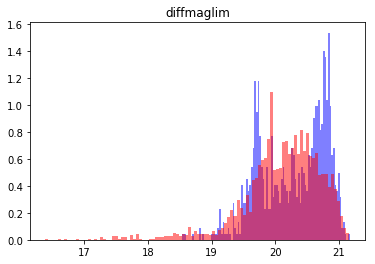

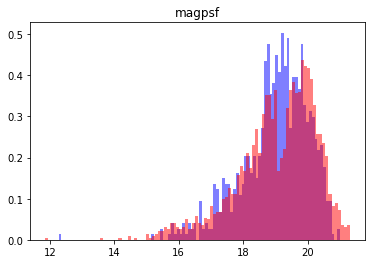

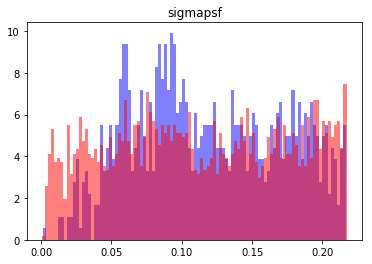

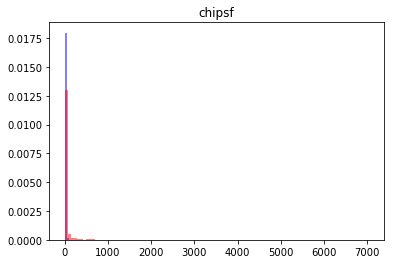

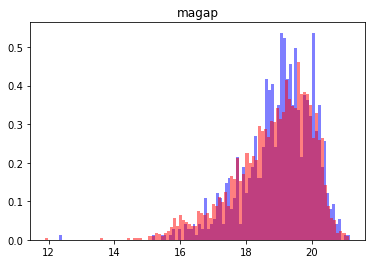

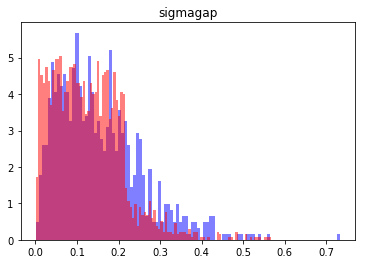

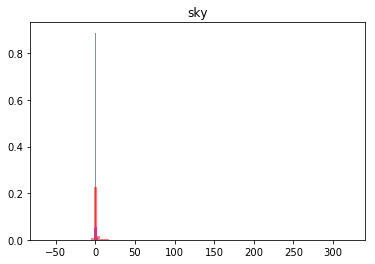

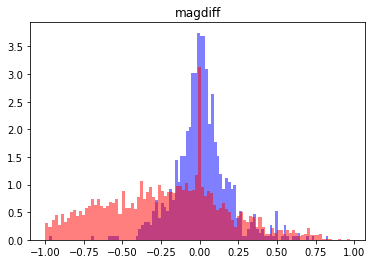

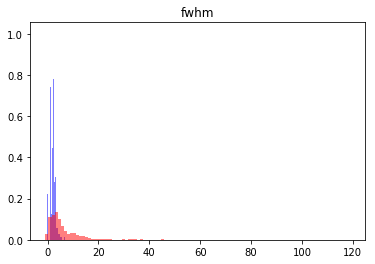

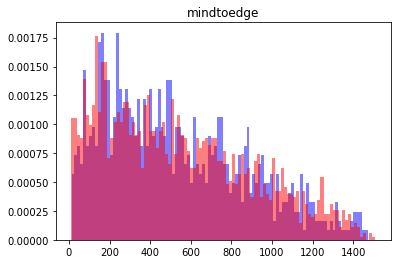

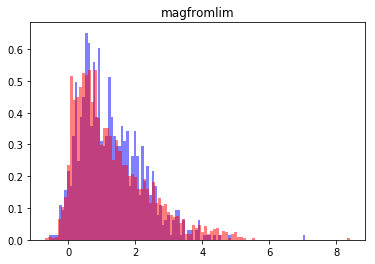

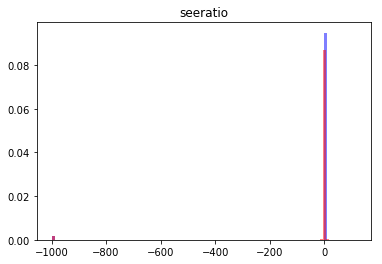

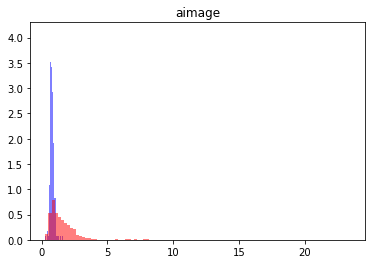

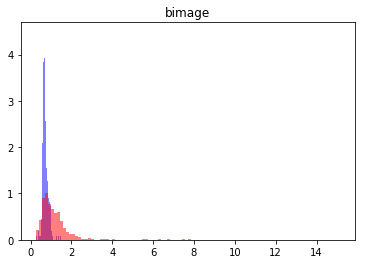

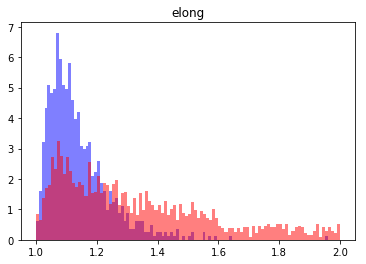

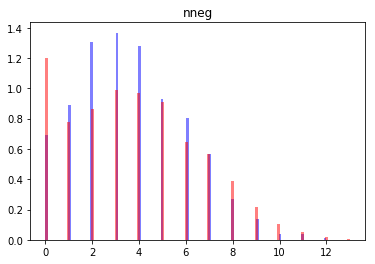

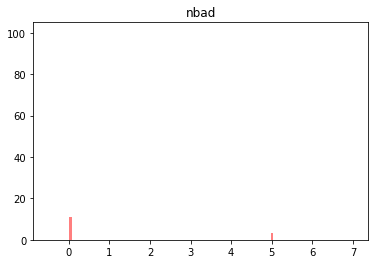

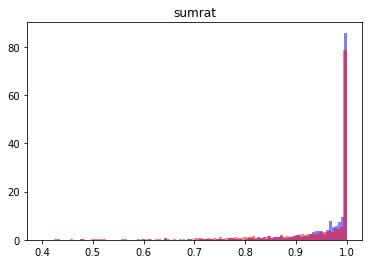

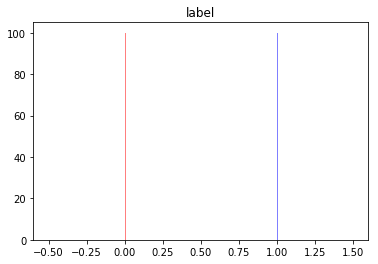

In [19]:
# Histogram a Single Feature
#
def plot_rb_hists(df, colname, bins=100, xscale='linear', yscale='linear'):
    mask_real = feats_df['label'] == 1
    mask_bogus = ~mask_real
    plt.hist(df[colname][mask_real], bins, color='b', alpha=0.5, normed=True)
    plt.hist(df[colname][mask_bogus], bins, color='r', alpha=0.5, normed=True)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(colname)
    plt.show()

# INSTRUCTION: Plot the individual features.  
#
for col in feats_df.columns:
    plot_rb_hists(feats_df,col)

In [67]:
exc_cols = ['label','nbad','seeratio']

#### Answer: 

- 'nbad' and 'nneg' are discrete features
- 'seeratio' has a sentinel value of -999
- There are some features that have high ranges than others.  For classifiers that are sensitive to scaling, we will need to scale the data
- There does not appear to be good separability between real and bogus on any individual features.

## 3. Curate a Test and Training Set

We need to reserve some of our labeled data for evaluation. This means we must split up the labeled data we have into the set used for training (training set), and the set used for evaluation (test set). Ideally, the distribution of real and bogus examples in both the training and test sets are roughly identical. One can use sklearn.model_selection.train_test_split and use the stratify option.

For ZTF data, we split the training and test data by date. That way repeat observations from the same night (which might be nearly identical) cannot be split into the training and test set, and artificially inflate test performance. Also, due to the change in survey objectives, it's possible that the test set features have drifted away from the training sets.

Provided is nid.npy which contains the Night IDs for ZTF. Split on nid=550 (July 5, 2018). This should leave you with roughly 500 examples in your test set.


In [33]:
from sklearn.model_selection import train_test_split

In [74]:
feats_plus_label = np.array(feats_df)
nids = meta_np['nid']

# INSTRUCTION: nid.npy contains the nids for this labeled data.
# Split the data into separate data structures for train/test data at nid=550.
# Verify that you have at least 500 reals in your test set.
train_df = feats_df[nids<=550]
test_df = feats_df[nids>550]

In [60]:
len(test_df)

604

In [62]:
len(train_df)

2586

## 4. Train a Classifier

#### Part 1: Separate Labels from the Features

Now store the labels separately from the features.  

In [75]:
# INSTRUCTION: Separate the labels from the features
y_train = train_df.label
y_test = test_df.label
X_train = train_df.drop(columns=exc_cols)
X_test = test_df.drop(columns=exc_cols)

In [76]:
X_train.columns

Index(['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap',
       'sky', 'magdiff', 'fwhm', 'mindtoedge', 'magfromlim', 'aimage',
       'bimage', 'elong', 'nneg', 'sumrat'],
      dtype='object')

#### Part 2. Scaling Data

With missing values handled, you're closing to training your classifiers.  However, because distance metrics can be sensitive to the scale of your data (e.g., some features span large numeric ranges, but others don't), it is important to normalize data within a standard range such as (0, 1) or with z-score normalization (scaling to unit mean and variance).  Fortunately, sklearn also makes this quite easy.  Please review sklearn's [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module options, specifically StandardScaler which corresponds to z-score normalization and MinMaxScaler.  Please implement one.  

FYI - Neural networks and Support Vector Machines (SVM) are sensitive to the scale of the data.  Decision trees (and therefore Random Forests) are not (but it doesn't hurt to use scaled data).

In [78]:
# INSTRUCTION: Re-scale your data using either the MinMaxScaler or StandardScaler from sklearn
#
scaler = StandardScaler()
sccale_fit = scaler.fit(feats_df.drop(columns=exc_cols))
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Part 3. Train Classifiers

Import a few classifiers and build models on your training data.  Some suggestions include a [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), [Neural Net](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier), [NaiveBayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) and [K-Nearest Neighbor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).  

In [92]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

knn3 = KNeighborsClassifier(3)
svml = SVC(kernel="linear", C=0.025, probability=True)
svmr = SVC(gamma=2, C=1, probability=True)
dtre = DecisionTreeClassifier()
rafo = RandomForestClassifier(n_estimators=100)
nnet = MLPClassifier(alpha=1)
naiv = GaussianNB()

knn3_fit = knn3.fit(X_train,y_train)
knn3_predict = knn3_fit.predict(X_test)
svml_fit=svml.fit(X_train,y_train)
svml_predict = svml_fit.predict(X_test)
svmr_fit=svmr.fit(X_train,y_train)
svmr_predict = svmr_fit.predict(X_test)
dtre_fit=dtre.fit(X_train,y_train)
dtre_predict = dtre_fit.predict(X_test)
rafo_fit=rafo.fit(X_train,y_train)
rafo_predict = rafo_fit.predict(X_test)
nnet_fit=nnet.fit(X_train,y_train)
nnet_predict = nnet_fit.predict(X_test)
naiv_fit=naiv.fit(X_train,y_train)
naiv_predict = naiv_fit.predict(X_test)


In [91]:
from sklearn import metrics


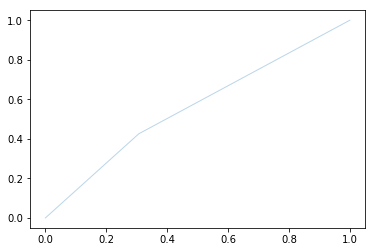

In [114]:
knn3_fit = knn3.fit(X_train,y_train)
knn3_predict = knn3_fit.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn3_predict)
plt.plot(fpr, tpr, lw=1, alpha=0.3)

In [123]:
# INSTRUCTION: Print out the following metrics per classifier into a table: accuracy, auc, f1_score, etc.
#

def bench_metrics(name, y_pred, y_test):
    
    print('%-9s\t%.3f\t\t%.3f\t%.3f\t\t%.3f\t%.3f'
          % (name,
             metrics.accuracy_score(y_test,y_pred),
             metrics.roc_auc_score(y_test,y_pred),
             metrics.precision_score(y_test,y_pred),
             metrics.recall_score(y_test,y_pred),
             metrics.f1_score(y_test, y_pred),
            ))

print(82 * '_')
print('init\t\taccuracy\tauc\tprecision\trecall\tf1_score')
print(82 * '_')
# INSTRUCTIONS: Use the bench_k_means method to compare your clustering results
#

for clf in clf_d:
    name = clf
    estimator = clf_d[clf]
    fit = estimator.fit(X_train,y_train)
    predict = fit.predict(X_test)
    labels = y_test
    bench_metrics(name,predict,labels)

__________________________________________________________________________________
init		accuracy	auc	precision	recall	f1_score
__________________________________________________________________________________
knn3     	0.575		0.559	0.525		0.425	0.470
svml     	0.613		0.600	0.575		0.485	0.526


/Users/Dan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


svmr     	0.556		0.500	0.000		0.000	0.000
dtre     	0.656		0.663	0.591		0.728	0.652
rafo     	0.728		0.730	0.676		0.746	0.709
nnet     	0.624		0.631	0.562		0.690	0.620
naiv     	0.526		0.573	0.483		0.981	0.648


In [97]:
for clf in clf_d:
    print(clf)

knn3
svml
svmr
dtre
rafo
nnet
naiv


In [96]:
clf_d = {'knn3':knn3,'svml':svml,'svmr':svmr,'dtre':dtre,'rafo':rafo,'nnet':nnet,'naiv':naiv}
# INSTRUCTION: Train at least three classifiers and run on your test data. Here's an example to get your started.  
# 
for clf in clfs:
    fit = clf.fit(X_train,y_train)
    score = fit.score(X_test,y_test)
    print(score)

0.574503311258
0.612582781457
0.556291390728
0.668874172185
0.725165562914
0.567880794702
0.526490066225


#### Part 4. Plot Real and Bogus Score Distributions

Another way to test performance is to plot a histogram of the test set RB scores, comparing the distributions of the labeled reals vs. boguses.  The scores of the reals should be close to 1, while the scores of the boguses should be closer to 0.  The more separated the distribution of scores, the better performing your classifier is.

Compare the score distributions of the classifiers you've trained.  Trying displaying as a cumulative distribution rather than straight histogram.  

*Optional:* What would the decision thresholds be at the  5% false negative rate (FNR)?  What would the decision threshold be at the 1% false positive rate?

In [ ]:
# INSTRUCTION: create masks for the real and bogus examples of the test set


# INSTRUCTION: First compare the classifiers' scores on the test reals only
#

scores_list = []
legends = ['Classifier 1', 'Classifier 2', 'Classifier 3'] # REPLACE ME
colors = ['g', 'b', 'r'] 
rbbins = np.arange(0,1,0.001)

# Comparison on real examples

plt.figure()
ax = plt.subplot(111)
for i, scores in enumerate(scores_list):
    # ax.hist() - COMPLETE ME
ax.set_xlabel('RB Score')
ax.set_ylabel('Count')
ax.set_xbound(0, 1)
ax.legend(legends, loc=4)
plt.show()


# Now perform the same comparison on bogus examples
#

## Refining

Now it's time to go back and start experimenting with different parameters.  If you have time, create a validation set and perform a Grid Search over a set of possible hyperparameters.  Compare different classifier results using the histograms above.